In [23]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, mean_absolute_error, mean_squared_error, r2_score


In [2]:
data = pd.read_csv('./data_files/clean_data.csv')

In [3]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head()

,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,last_owned
0,SOLD,105000,3.0,2.0,0.12,Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,Not Owned
1,SOLD,80000,4.0,2.0,0.08,Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,Not Owned
2,SOLD,67000,2.0,1.0,0.15,556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,Not Owned
3,SOLD,145000,4.0,2.0,0.10,R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,Not Owned
4,SOLD,65000,6.0,2.0,0.05,14 Navarro,Mayaguez,Puerto Rico,680.0,1000.0,Not Owned


In [4]:
len(data['zip_code'].unique())

758

There are still indiviual dates in the Last_owned column so it will end up OHE each indiviual date to fix that instead of spearating by Not Previously owned and a date it will just be Not Owned or Owned essentially making it a binary 0 or 1 

In [5]:
data.loc[data['last_owned'] != "Not Owned", 'last_owned'] = 'Owned'

In [6]:
data['last_owned'].value_counts()

Not Owned    9424
Owned        5295
Name: last_owned, dtype: int64

Since there are 12 different states and not all of them are distributed evenly this offsets the predictions heavly to combat this only taking the top 4 states that are close in distribution will significatly help the models where as having the other 8 states hurts the models trumendusly 

In [7]:
data['state'].value_counts()

Connecticut       3863
Massachusetts     3840
Puerto Rico       2632
Rhode Island      2037
New York           767
Virgin Islands     742
New Hampshire      601
Vermont            233
New Jersey           1
Tennessee            1
South Carolina       1
Virginia             1
Name: state, dtype: int64

In [8]:
data= data[data['state'].isin(['Connecticut', 'Massachusetts', 'Puerto Rico', 'Rhode Island'])]

In [9]:
X = data.drop(columns=['price', 'street', 'zip_code'])
y = data['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_train = X_train[['status', 'last_owned', 'city', 'state']]
ohe_test = X_test[['status', 'last_owned', 'city', 'state']]

ohe_train = ohe.fit_transform(ohe_train)
ohe_test = ohe.transform(ohe_test)

In [12]:
scaler = StandardScaler()

scaled_train = X_train[['bed','bath','acre_lot','house_size']]
scaled_test = X_test[['bed','bath','acre_lot','house_size']]

scaled_train = scaler.fit_transform(scaled_train)
scaled_test  = scaler.transform(scaled_test)

In [13]:
X_train = np.concatenate((scaled_train ,ohe_train), axis=1)
X_test = np.concatenate((scaled_test ,ohe_test), axis=1)

In [168]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)

print(f'Training: {knn.score(X_train, y_train)}')
print(f'Testing: {knn.score(X_test, y_test)}')

Training: 0.5461052923365501
Testing: 0.21755264382480977


LGBM

In [14]:
X = data.drop(columns=['price'])
y = data['price']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [16]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_train = X_train[['status', 'last_owned','street', 'zip_code', 'city', 'state']]
ohe_test = X_test[['status', 'last_owned','street', 'zip_code', 'city', 'state']]

ohe_train = ohe.fit_transform(ohe_train)
ohe_test = ohe.transform(ohe_test)

In [17]:
scaler = StandardScaler()

scaled_train = X_train[['bed','bath','acre_lot','house_size']]
scaled_test = X_test[['bed','bath','acre_lot','house_size']]

scaled_train = scaler.fit_transform(scaled_train)
scaled_test  = scaler.transform(scaled_test)

In [18]:
X_train = np.concatenate((scaled_train ,ohe_train), axis=1)
X_test = np.concatenate((scaled_test ,ohe_test), axis=1)

In [19]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,y_train)

LGBMRegressor()

In [20]:
print('Training accuracy:', lgbm.score(X_train, y_train))
print('Testing accuracy:', lgbm.score(X_test, y_test))

Training accuracy: 0.6699819393955146
Testing accuracy: 0.48507438949363957


In [187]:
lgbm_params={
    'force_col_wise' : [True, False], 
    'force_row_wise' : [True, False], 
    'max_depth' : [5,10,25,50,100], 
    'extra_trees' : [True, False],
    'drop_seed' : [4, 8, 12, 24, 36]
}

In [188]:
grid = GridSearchCV(LGBMRegressor(), param_grid=lgbm_params)

grid.fit(X_train,y_train)

c:\Users\sreno\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\sreno\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sreno\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\Users\sreno\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    self._Booster = train(params, train_set,
  File "c:\Users\sreno\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "c:\Users\sreno\anaconda3\lib\site-packages\lightgbm\basic.py", line 2234, in __init__
    _safe_call(_LIB.LGBM_BoosterCrea

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'drop_seed': [4, 8, 12, 24, 36],
                         'extra_trees': [True, False],
                         'force_col_wise': [True, False],
                         'force_row_wise': [True, False],
                         'max_depth': [5, 10, 25, 50, 100]})

In [189]:
grid.best_params_

{'drop_seed': 4,
 'extra_trees': True,
 'force_col_wise': True,
 'force_row_wise': False,
 'max_depth': 10}

Default is better

In [190]:
lgbm = LGBMRegressor(drop_seed= 4, extra_trees= True,force_col_wise= True,force_row_wise= False,max_depth=10)
lgbm.fit(X_train,y_train)

print('Training accuracy:', lgbm.score(X_train, y_train))
print('Testing accuracy:', lgbm.score(X_test, y_test))

Training accuracy: 0.5278599553864833
Testing accuracy: 0.4501368457127449


In [21]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,y_train)

print('Training accuracy:', lgbm.score(X_train, y_train))
print('Testing accuracy:', lgbm.score(X_test, y_test))

Training accuracy: 0.6699819393955146
Testing accuracy: 0.48507438949363957


In [24]:
lgbm_train_pred = lgbm.predict(X_train)
lgbm_test_pred = lgbm.predict(X_test)


lgbm_rmse_train = np.sqrt(mean_squared_error(y_train, lgbm_train_pred))
lgbm_mse_train = mean_squared_error(y_train, lgbm_train_pred)
lgbm_mae_train = mean_absolute_error(y_train, lgbm_train_pred)
lgbm_r2_train = r2_score(y_train, lgbm_train_pred)

#testing scores
lgbm_rmse_test = np.sqrt(mean_squared_error(y_test, lgbm_test_pred))
lgbm_mse_test = mean_squared_error(y_test, lgbm_test_pred)
lgbm_mae_test = mean_absolute_error(y_test, lgbm_test_pred)
lgbm_r2_test = r2_score(y_test, lgbm_test_pred)


print(f'Training Score =   r2: {lgbm_r2_train}   rmse: {lgbm_rmse_train}   mse: {lgbm_mse_train}   mae: {lgbm_mae_train} ')
print(f'Testing Score =   r2: {lgbm_r2_test}   rmse: {lgbm_rmse_test}   mse: {lgbm_mse_test}   mae: {lgbm_mae_test} ')


Training Score =   r2: 0.6699819393955146   rmse: 715337.9129308119   mse: 511708329676.20984   mae: 217069.36684083965 
Testing Score =   r2: 0.48507438949363957   rmse: 728382.7391645446   mse: 530541414712.84503   mae: 244385.96333322188 


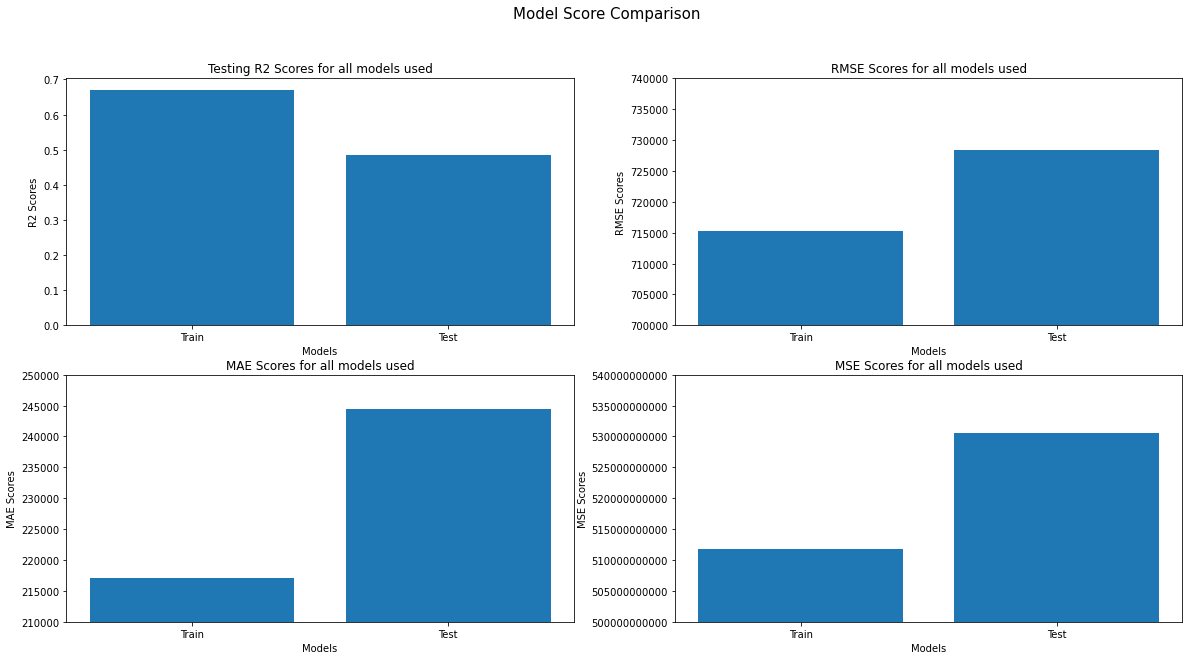

In [50]:
r2scores = [lgbm_r2_train, lgbm_r2_test]
rmsescores = [lgbm_rmse_train, lgbm_rmse_test]
maescores = [lgbm_mae_train, lgbm_mae_test]
msescores= [lgbm_mse_train, lgbm_mse_test]
names = ['Train', 'Test']

fig = plt.figure(figsize=(20,10))
fig.suptitle('Model Score Comparison', fontsize=15)

ax1= plt.subplot(221)
ax2= plt.subplot(222)
ax3= plt.subplot(223)
ax4= plt.subplot(224)


ax1.bar(names, r2scores)
ax1.set_title('Testing R2 Scores for all models used')
ax1.set_ylabel('R2 Scores')
ax1.set_xlabel('Models')




ax2.bar(names, rmsescores)
ax2.set_title('RMSE Scores for all models used')
ax2.set_ylabel('RMSE Scores')
ax2.set_ylim(700000, 740000)
ax2.set_xlabel('Models')

ax3.bar(names, maescores)
ax3.set_title('MAE Scores for all models used')
ax3.set_ylabel('MAE Scores')
ax3.set_ylim(210000, 250000)
ax3.set_xlabel('Models')



ax4.bar(names, msescores)
ax4.set_title('MSE Scores for all models used')
ax4.set_ylabel('MSE Scores')
ax4.set_ylim(500000000000, 540000000000)
ax4.ticklabel_format(style='plain', axis='y')
ax4.set_xlabel('Models')
plt.show()

